<a href="https://colab.research.google.com/github/vamado09/Applied-Data-Science/blob/main/Homework3_VicenteDeLeon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vicente De Leon

IU_id: 2001014594

APPLIED DATA SCIENCE: 9998

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Twitch Dataset

Twitch dataset of users consuming streaming content on Twitch. The data collectors retrieved all streamers, and all users in their respective chats, every 10 minutes during 43 days. Start and stop times are provided as integers and represent periods of 10 minutes.

Source: https://cseweb.ucsd.edu/~jmcauley/datasets.html#twitch

You can get this data, the 100k (not the full), from the data collector's one drive.

In [2]:
df = pd.read_csv('/content/100k_a.csv')
df.head()

,1,33842865744,mithrain,154,156
0,1,33846768288,alptv,166,169
1,1,33886469056,mithrain,587,588
2,1,33887624992,wtcn,589,591
3,1,33890145056,jrokezftw,591,594
4,1,33903958784,berkriptepe,734,737


In [3]:
column_names = ['User ID', 'Stream ID', 'Streamer Username', 'Time Start', 'Time Stop']
df = pd.read_csv('/content/100k_a.csv', names = column_names, header = None)
df.head()

,User ID,Stream ID,Streamer Username,Time Start,Time Stop
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594


In [4]:
df['Duration'] = df['Time Stop'] - df['Time Start']

The dataset is kind of limited, due to this, the recommender system that will be created is Collaborative Filtering. This Twitch dataset shows potential for this type of recommendation system because of the shared `User ID` and `Streamer Username` interactions. Two ideas I have in mind are for example User 1 has interacted with `mithrain`, `wtcn`, `jrokezftw`, then collaborative filtering can assume other users who interacted with some of these streamers might also like the rest. Also, `mithrain` and `wtcn` are likely connected if many users interact with both. This could help recommened similar streamers to users with overlapping preferences.

In [ ]:
unique_user_ids = df['User ID'].unique()
print(unique_user_ids)

[     1      2      3 ...  99998  99999 100000]


In [ ]:
unique_streamer_ids = df['Stream ID'].unique()
print(unique_streamer_ids)

[33842865744 33846768288 33886469056 ... 34306191808 34310064496
 34412194176]


In [ ]:
df.shape[0]

3051733

In [ ]:
df.isnull().sum()

,0
User ID,0
Stream ID,0
Streamer Username,0
Time Start,0
Time Stop,0


In [ ]:
df.dtypes

,0
User ID,int64
Stream ID,int64
Streamer Username,object
Time Start,int64
Time Stop,int64


In [ ]:
df.describe()

,User ID,Stream ID,Time Start,Time Stop
count,3.051733e+06,3.051733e+06,3.051733e+06,3.051733e+06
mean,5.032313e+04,3.413002e+10,3.146044e+03,3.149186e+03
std,2.889476e+04,1.682242e+08,1.772520e+03,1.772656e+03
min,1.000000e+00,3.380153e+10,0.000000e+00,1.000000e+00
25%,2.528400e+04,3.398884e+10,1.618000e+03,1.620000e+03
50%,5.029900e+04,3.413069e+10,3.174000e+03,3.178000e+03
75%,7.545200e+04,3.427399e+10,4.676000e+03,4.679000e+03
max,1.000000e+05,3.441642e+10,6.147000e+03,6.148000e+03


We see that we have no missing values and the data type are appropriate for the columns (IDs and times as integeres and usernames as objects). We also have a wide range of users (100k unique IDs) interactong with various streamers over a dataset of about 3.0M interactions, which provides a good volume for a collborative filtering.

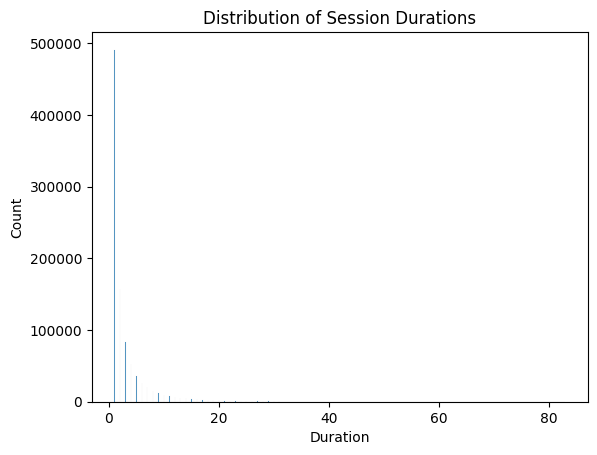

In [ ]:
sns.histplot(df['Duration'])
plt.title('Distribution of Session Durations')
plt.show()

It seemes that most session durations are quite short, with a significant spike at very short durations. This could indicate that many users pop into streams but don't stay long, possibly browsing or checking out different streamers quickly? Who knows..

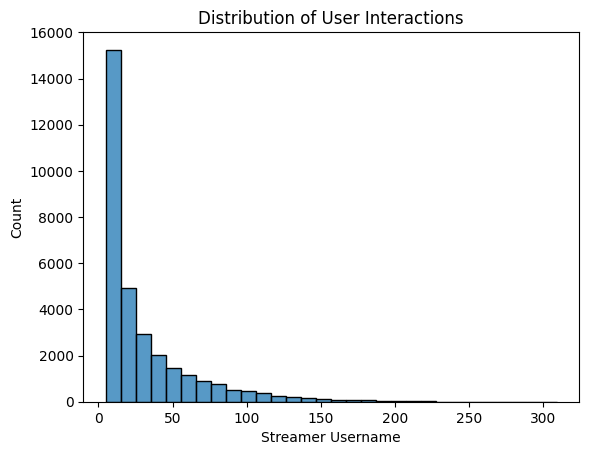

In [ ]:
user_interactions = df.groupby('User ID')['Streamer Username'].count()
sns.histplot(user_interactions, bins=30)
plt.title('Distribution of User Interactions')
plt.show()

It also seemes that the majority of users interact with only a few streamers. This suggests a long tail distribution where a few users are very active while most are less so.

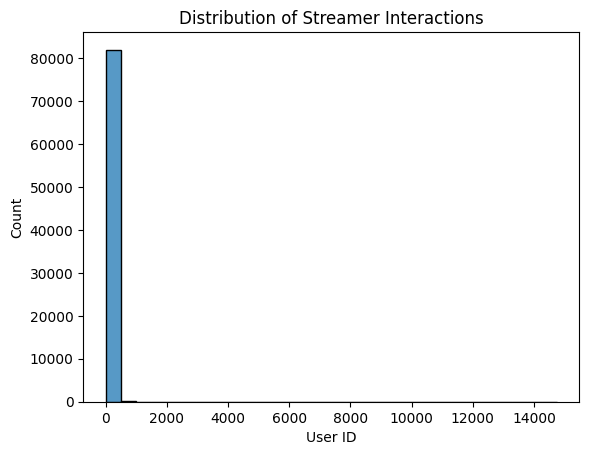

In [ ]:
streamer_interactions = df.groupby('Streamer Username')['User ID'].count()
sns.histplot(streamer_interactions, bins=30)
plt.title('Distribution of Streamer Interactions')
plt.show()

Just like user interactions, a few streamers receive a disproportionately high amount of traffic, which is typical in platforms like Twitch.

# Recommender System: Collaborative Filtering

Collaborative Filtering recommends items based on similarity measures between users and/or items. The basic assumption behind the algorithm is that users with similar interests have common preferences. `In this type of recommendation system, we don’t use the features of the item to recommend it, rather we classify the users into clusters of similar types and recommend each user according to the preference of its cluster.`

This syste, uses a user-item matrix to generate recommendations. This matrix contains the values that indicate a user’s preference towards a given item. These values can represent either explicit feedback (direct user ratings) or implicit feedback (indirect user behavior such as listening, purchasing, watching).

There are two types of Collaborative Filtering available:

- User-User-based Similarity/Collaborative Filtering
- Item-Item-based Similarity/Collaborative Filtering

## Logarithmic Transformation:

Since session durations vary and most are very short, we could apply some logarithmic transformation for normalization, which could then by used as weights for the interactions. This will help in reducing the impact of very larget values and making the distribution less skewed.

Tips: https://juandelacalle.medium.com/best-tips-and-tricks-when-and-why-to-use-logarithmic-transformations-in-statistical-analysis-9f1d72e83cfc#:~:text=Skewed%20data%20can%20make%20it,symmetrical%20and%20easier%20to%20analyze.


I tried running the interaction matrix below, but my session crashed after using all available RAM. I guess this is normal since we're currently handling large datasets, building this type of matrix can indeed consume lots of memory. That's why I will be creating a sparse matrix that only stores non-zero entries (significantly reducing memoery usage).

In [ ]:
# df['Log Duration'] = np.log1p(df['Duration'])

# Creating a user-item interaction matrix using -> transform durantion
# interaction_matrix = df.pivot_table(index = 'User ID', columns = 'Streamer Username', values = 'Log Duration', aggfunc = 'sum', fill_value = 0)
# interaction_matrix.head()

In [5]:
df['Log Duration'] = np.log1p(df['Time Stop'] - df['Time Start'])

# Sparse matrix
user_indices = df['User ID'].astype('category').cat.codes # pandas series documentation
streamer_indices = df['Streamer Username'].astype('category').cat.codes

sparse_matrix = csr_matrix((df['Log Duration'], (user_indices, streamer_indices)), shape=(df['User ID'].nunique(), df['Streamer Username'].nunique()))

In [ ]:
print(sparse_matrix)

  (0, 5331)	1.3862943611198906
  (0, 13842)	1.3862943611198906
  (0, 39233)	1.3862943611198906
  (0, 40426)	0.6931471805599453
  (0, 40828)	0.6931471805599453
  (0, 52824)	2.7080502011022096
  (0, 53860)	0.6931471805599453
  (0, 64456)	4.0943445622221
  (0, 68370)	2.0794415416798357
  (0, 68480)	2.3025850929940455
  (0, 71964)	8.723231274827507
  (0, 92273)	6.356107660695891
  (0, 103339)	2.772588722239781
  (0, 115138)	2.0794415416798357
  (0, 144902)	2.995732273553991
  (0, 148539)	2.7080502011022096
  (0, 155056)	5.598421958998374
  (0, 161054)	3.1780538303479458
  (0, 161322)	1.791759469228055
  (1, 18885)	4.564348191467836
  (1, 22829)	1.791759469228055
  (1, 34327)	1.791759469228055
  (1, 51486)	0.6931471805599453
  (1, 52913)	1.3862943611198906
  (1, 54553)	0.6931471805599453
  :	:
  (99997, 1455)	0.6931471805599453
  (99997, 22849)	3.1780538303479458
  (99997, 23344)	0.6931471805599453
  (99997, 161455)	0.6931471805599453
  (99998, 39529)	0.6931471805599453
  (99998, 40834)	1.3

This matrix represents user interactions with streamers, now let's use this sparse matrix to compute similarities and make some recommendations.After the initial sparse matrix is created, we need to split the data into training, validation, and testing sets!

## Train Test Split

In [ ]:
nonzero_rows, nonzero_cols = sparse_matrix.nonzero()
data_values = sparse_matrix.data

indices = np.vstack((nonzero_rows, nonzero_cols)).T # combining row and column indices for splitting data

# Train and Test Sets
indices_train_val, indices_test, data_train_val, data_test = train_test_split(indices, data_values, test_size = 0.2, random_state = 42)

# Let's include validation -> always good to include
indices_train, indices_val, data_train, data_val = train_test_split(indices_train_val, data_train_val, test_size=0.2, random_state = 42)

Rebuilding sparse matrices:

In [ ]:
train_row_indices, train_col_indices = indices_train.T
val_row_indices, val_col_indices = indices_val.T
test_row_indices, test_col_indices = indices_test.T

X_train = csr_matrix((data_train, (train_row_indices, train_col_indices)), shape = sparse_matrix.shape)
X_val = csr_matrix((data_val, (val_row_indices, val_col_indices)), shape = sparse_matrix.shape)
X_test = csr_matrix((data_test, (test_row_indices, test_col_indices)), shape = sparse_matrix.shape)

## Cosine Similarity

$$
\text{cosine similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$

- sparse from spmatrix Pandas: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sparse.from_spmatrix.html

In [ ]:
cosine_sim = cosine_similarity(X_train.T, dense_output = False)

streamer_ids = df['Streamer Username'].astype('category').cat.categories
cosine_sim_df = pd.DataFrame.sparse.from_spmatrix(cosine_sim, index=streamer_ids, columns=streamer_ids) # for easier handling

cosine_sim_df.head()

,0007_hot_kelly_tv,000aikia000,0011am,001_ssmashh_100,001live,002ivorkdorog,007kingchannel,007zeus,00elu00,00fero00,...,zzzireael,zzzjpn,zzzksazzz1,zzzombie_girl,zzztaff,zzztantrikazzz,zzzz1123x2018,zzzz758,zzzzydh,zzzzzzzach
0007_hot_kelly_tv,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000aikia000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0011am,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001_ssmashh_100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001live,0,0,0,0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's see what's going on:

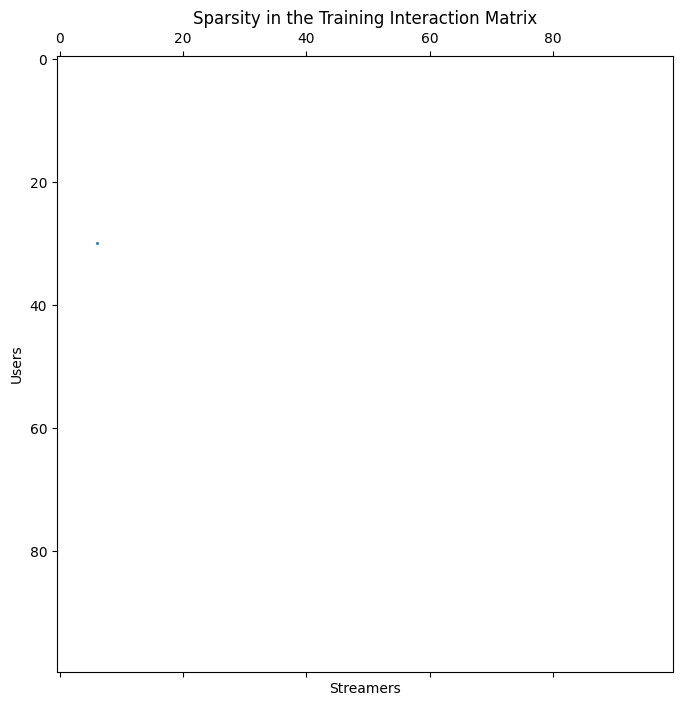

In [ ]:
# Small subset of the interaction matrix
plt.figure(figsize=(10, 8))
plt.spy(X_train[:100, :100], markersize = 1)
plt.title('Sparsity in the Training Interaction Matrix')
plt.xlabel('Streamers')
plt.ylabel('Users')
plt.show()

The above visualization, shows that Cosine Similarity isn't returning good results due to the extreme sparsity of the Twitch dataset. I intially thought of doing Collaborative Filtering here, however this is a case of extreme data sparsity. I can't do User-Based either because my session crashes due to the high computational demand plus, I could say the X_train matrix has 90% or even more sparsity. With spares data, most streamers don't have overlapping audiences, so this will crash.

I will have to jump into other alternatives to similarity - based filtering. I will need to search for a method that does not require explicit utem-item or user-user similarities, which could potentially effective for sparse datasets like this one.

In [ ]:
# Getting a sample of real user indices from the dataset
real_user_indices = df['User ID'].astype('category').cat.codes.unique()
print('Sample User Indices:', real_user_indices[:5])  # first 5 user indices

Sample User Indices: [0 1 2 3 4]


# PySpark: Starting All Over

After multiple attempts and failed experiments using SVD and neural networks to build a recommendation system (even resulting in 0.00 for both Recall and F-1 scores) I grew frustrated with frequent session crashes! As a result, I decided to change direction and apply what I learned in the Big Data Application course I took about a year ago. In this new approach, I will be using Apache Spark along with a subset of the Twitch dataset. This seems like a much more reliable method, let's see how it goes. One thing I learned is that Cosine Similarity seeemes not do well with sparse data....

Source: https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/index.html

Great resource: https://medium.com/@brunoborges_38708/recommender-system-using-als-in-pyspark-10329e1d1ee1

geeks for geeks: https://www.geeksforgeeks.org/recommender-system-using-pyspark-python/

In [1]:
!pip install pyspark

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.functions import log1p
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import min, max
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

In [5]:
spark = SparkSession.builder \
    .appName('HW3 Recommendation System') \
    .getOrCreate()

The above recommendation system with PySpark was a very useful for this experimenation. I will convert the User ID and Streamer Username to numeric indices as well as calculating the log duration. Just like we did before, I'm going to be calculating the duration and applying logarithmic transformation to the duration to handle scale disparities and improve model performance.

In [6]:
sdf = spark.createDataFrame(df)

The `log1p` transformation requires positive input. If Duration is zero or negative, it will cause errors (crazy errors).

In [7]:
sdf = sdf.withColumn('Duration', col('Time Stop') - col('Time Start'))
sdf = sdf.filter(col('Duration') > 0)  # filterinh out invalid durations
sdf = sdf.withColumn('Log Duration', log1p(col('Duration')))
sdf = sdf.withColumnRenamed('Log Duration', 'log_duration')
sdf = sdf.withColumn('rating', col('log_duration').cast('float'))

# StringIndexer
user_indexer = StringIndexer(inputCol = 'User ID', outputCol = 'userId')
sdf = user_indexer.fit(sdf).transform(sdf)

item_indexer = StringIndexer(inputCol = 'Streamer Username', outputCol = 'itemId')
sdf = item_indexer.fit(sdf).transform(sdf)

# Dropping nulls in key columns
sdf = sdf.dropna(subset = ['userId', 'itemId', 'rating'])

I will create a smaller dataframe for quick testing. Although Apache Spark is designed to handle big data, Colab's free tier provides only 12.7 GB of RAM. At this point, I’m not willing to take the risk, which is why I will work with a smaller chunk of data for experimentation. I've been facing way too much session crashes.

In [8]:
subset_sdf = sdf.sample(withReplacement = False, fraction = 0.1, seed = 42)
X_train, y_test = subset_sdf.randomSplit([0.8, 0.2], seed = 42)

## PySpark ALS

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. spark.ml currently supports model-based collaborative filtering, in which users and products are described by a small set of latent factors that can be used to predict missing entries. spark.ml uses the alternating least squares (ALS) algorithm to learn these latent factors.

`Cold start strategy`

When making predictions using an ALSModel, it is common to encounter users and/or items in the test dataset that were not present during training the model. This typically occurs in two scenarios:

- In production, for new users or items that have no rating history and on which the model has not been trained (this is the “cold start problem”).

- During cross-validation, the data is split between training and evaluation sets. When using simple random splits as in Spark’s CrossValidator or TrainValidationSplit, it is actually very common to encounter users and/or items in the evaluation set that are not in the training set

Setting Cold Strategy to `drop`.

ALS PySpark Documentation: https://spark.apache.org/docs/latest/ml-collaborative-filtering.html

Resource: https://www.geeksforgeeks.org/recommender-system-using-pyspark-python/

In [9]:
als = ALS(maxIter = 5,
          regParam = 0.01,
          userCol = 'userId',
          itemCol = 'itemId',
          ratingCol = 'rating',
          coldStartStrategy = 'drop',
          nonnegative = True) # I wan non negative predictions -> this will help

model = als.fit(X_train)

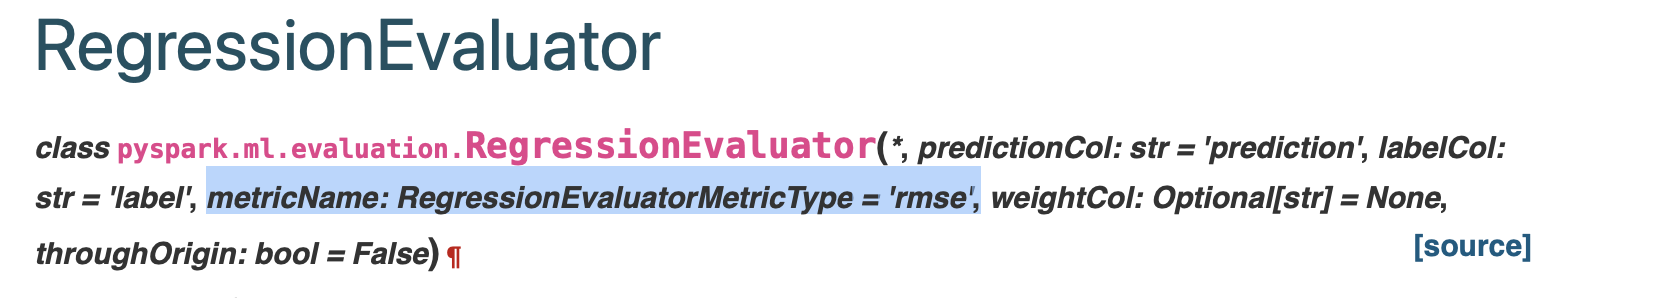

In [12]:
predictions = model.transform(y_test)
predictions = predictions.na.fill(0, ['prediction']) # to handle any NaN predictions due to the Cold Strategy problems

evaluator = RegressionEvaluator(metricName = 'rmse', labelCol = 'rating', predictionCol = 'prediction')
rmse = evaluator.evaluate(predictions)

print(f"Root mean square error = {rmse}")

Root mean square error = 0.9173257501525796


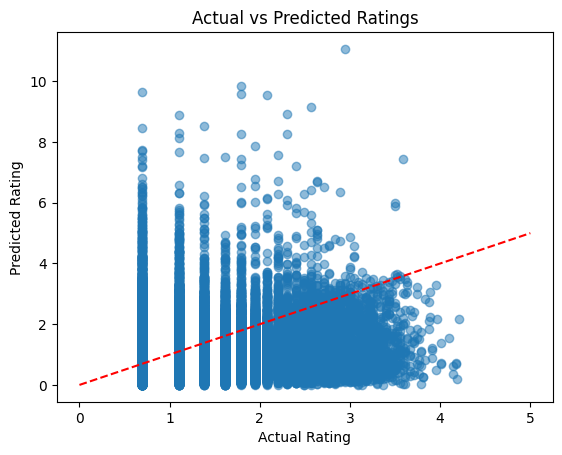

In [15]:
df = predictions.select('rating', 'prediction').toPandas()

plt.scatter(df['rating'], df['prediction'], alpha = 0.5)
plt.plot([0, 5], [0, 5], 'r--')  # Reference line
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings')
plt.show()

The visualization shows that the model seemes to struggles to consistently predict low values accurately. It also seemes to overestimate ratings and for the actual ratings closer to the maximum, predictions tend to fall below the actual values. The model is less effective at capturing the true relationship between input features and rating, especially for low actual values.

The RMSE score of 0.917 shows as a moderate error relative to the rating scale.

## Item Based Recommendation

In [10]:
itemRecs = model.recommendForAllItems(5) # let's do 5 recommendations
itemRecs.show(truncate = False)

+------+----------------------------------------------------------------------------------------------------+
|itemId|recommendations                                                                                     |
+------+----------------------------------------------------------------------------------------------------+
|1     |[{10374, 3.7239594}, {41505, 3.334052}, {59514, 3.2131264}, {7321, 3.168027}, {79484, 3.1380966}]   |
|3     |[{12109, 3.9837198}, {51887, 3.8680894}, {31401, 3.7807112}, {46787, 3.712934}, {74954, 3.5974905}] |
|5     |[{51849, 3.7059326}, {12766, 3.2664027}, {15060, 3.198071}, {42441, 3.009997}, {35763, 2.8651676}]  |
|6     |[{42722, 3.6318262}, {83637, 3.3431003}, {19966, 3.241619}, {34928, 3.2375567}, {29176, 3.0843897}] |
|9     |[{6259, 3.5437129}, {19923, 3.395429}, {9390, 3.2694778}, {6433, 3.213045}, {7565, 3.153066}]       |
|12    |[{21849, 3.488797}, {19966, 3.4756336}, {47306, 3.340583}, {55764, 3.016676}, {7321, 2.967362}]     |
|13    |[{

- userId: The ID of a user recommended for this item.
- rating: The predicted rating the user would give to the item.


WE have top 5 user that most likely to interact with itemId based on their preferences and the latent factors learned by the model.

For example, User 10374 would rate itemId = 1 as 3.7239594 etc.

## User Based Recommendation

In [11]:
userRecs = model.recommendForAllUsers(5) # let's do 5 recommendations
userRecs.show(truncate = False)

+------+----------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                     |
+------+----------------------------------------------------------------------------------------------------+
|1     |[{59999, 3.8387432}, {22777, 3.7258933}, {31303, 3.6728919}, {17295, 3.67007}, {11364, 3.627035}]   |
|3     |[{11364, 7.869738}, {31303, 7.513164}, {25366, 6.7037096}, {13691, 6.57034}, {5725, 6.5213737}]     |
|5     |[{120955, 8.795002}, {18672, 7.687268}, {20455, 7.2688766}, {10154, 6.9279833}, {17295, 6.621632}]  |
|6     |[{6702, 7.451129}, {20728, 6.31297}, {36779, 5.847843}, {40533, 5.6698155}, {115221, 5.432984}]     |
|9     |[{20728, 10.041211}, {56561, 7.8058076}, {13691, 7.725658}, {16472, 7.7157187}, {26516, 7.5271354}] |
|12    |[{107631, 6.7092943}, {4641, 5.6783514}, {4256, 5.6137114}, {17295, 5.566579}, {29707, 5.291094}]   |
|13    |[{

Same approach is being followed here, User 1 would rate itemId = 59999 as 33.8387432 etc..

## Additional Experimentation: Normalization and ALS Rating Weights Simulation

Let's try normalizing the data first and also using weights. From what I've read, it seems ALS doesn't orginally support weights. However, we could simulate weighting by creating a weighted rating column?

In [9]:
# Calculating th min and max of the rating column
rating_min = sdf.agg(min(col('rating'))).collect()[0][0]
rating_max = sdf.agg(max(col('rating'))).collect()[0][0]

# Normalizing ratings to a [0, 1] range
sdf = sdf.withColumn('rating_normalized', (col('rating') - rating_min) / (rating_max - rating_min))

In [10]:
# Calculating counts for each rating value
rating_counts = sdf.groupBy('rating_normalized').count().collect()

# Computing weights
total_count = sum(row['count'] for row in rating_counts)
rating_weights = {row['rating_normalized']: total_count / row['count'] for row in rating_counts}

# Adding a weight column based on normalized rating
weight_udf = udf(lambda r: rating_weights.get(r, 1.0), FloatType())
sdf = sdf.withColumn('weight', weight_udf(col('rating_normalized')))

In [14]:
sdf = sdf.withColumn('weighted_rating', col('rating_normalized') * col('weight'))

In [15]:
subset_sdf = sdf.sample(withReplacement = False, fraction = 0.1, seed = 42)
X_train, y_test = subset_sdf.randomSplit([0.8, 0.2], seed = 42)

In [16]:
# I want to check and see if the columns I needed (like weighted rating) were succesfully created
sdf.printSchema()
sdf.show(5)

root
 |-- User ID: long (nullable = true)
 |-- Stream ID: long (nullable = true)
 |-- Streamer Username: string (nullable = true)
 |-- Time Start: long (nullable = true)
 |-- Time Stop: long (nullable = true)
 |-- Duration: long (nullable = true)
 |-- log_duration: double (nullable = true)
 |-- rating: float (nullable = true)
 |-- userId: double (nullable = false)
 |-- itemId: double (nullable = false)
 |-- rating_normalized: double (nullable = true)
 |-- weight: float (nullable = true)
 |-- weighted_rating: double (nullable = true)

+-------+-----------+-----------------+----------+---------+--------+------------------+---------+-------+------+-------------------+---------+------------------+
|User ID|  Stream ID|Streamer Username|Time Start|Time Stop|Duration|      log_duration|   rating| userId|itemId|  rating_normalized|   weight|   weighted_rating|
+-------+-----------+-----------------+----------+---------+--------+------------------+---------+-------+------+-------------------+-

In [17]:
als = ALS(
    maxIter = 5,
    regParam = 0.01,
    userCol = 'userId',
    itemCol = 'itemId',
    ratingCol = 'weighted_rating',
    coldStartStrategy = 'drop',
    nonnegative = True
)

model = als.fit(X_train)

In [18]:
predictions = model.transform(y_test)
predictions = predictions.na.fill(0, ['prediction'])


evaluator = RegressionEvaluator(
    metricName = 'rmse',
    labelCol = 'rating_normalized',
    predictionCol = 'prediction'
)


rmse = evaluator.evaluate(predictions)
print(f"Root Mean Square Error after normalization and weighting = {rmse}")

Root Mean Square Error after normalization and weighting = 1724.8493546464308


Failed, this is way too off.

I'm going to stick to the original RMSE of 0.9173257501525796. While this RMSE is not perfect, it might sugest the model captures some meaningful patterns in the data.

# Citation:

Recommendation on Live-Streaming Platforms: Dynamic Availability and Repeat Consumption
Jérémie Rappaz, Julian McAuley and Karl Aberer
RecSys, 2021

## Sources:

- Recommendation System: https://www.geeksforgeeks.org/recommendation-system-in-python/

- Intro to LaTex: https://colab.research.google.com/github/bebi103a/bebi103a.github.io/blob/main/lessons/00/intro_to_latex.ipynb

- Cosine Similarity: https://naomy-gomes.medium.com/the-cosine-similarity-and-its-use-in-recommendation-systems-cb2ebd811ce1

- Cosine Similarity: https://en.wikipedia.org/wiki/Cosine_similarity

- Pandas Sparse Matrix: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sparse.from_spmatrix.html

- Collaborative Filtering: https://www.analyticsvidhya.com/blog/2022/02/introduction-to-collaborative-filtering/

- Collaborative Filtering: https://towardsdatascience.com/recommendation-system-part-1-use-of-collaborative-filtering-and-hybrid-collaborative-content-in-6137ba64ad58

- Collaborative Filtering: https://www.geeksforgeeks.org/collaborative-filtering-ml/

- Logarithmic Transformation: https://www.statology.org/transform-data-in-python/

- SciPy Sparde data: https://www.w3schools.com/python/scipy/scipy_sparse_data.php

- Bulding Sparse matrix: https://www.geeksforgeeks.org/how-to-create-a-sparse-matrix-in-python/

- SciPy recommendation: https://docs.scipy.org/doc/scipy/reference/sparse.html

- Pandas Series documentation: https://pandas.pydata.org/docs/reference/api/pandas.Series.cat.codes.html

- Item Based Collaborative Filtering: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d

- SKlearn Cosine Similarity: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

- PySpark: https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/index.html

- Reccomendation system using PySpark ALS model: https://medium.com/@brunoborges_38708/recommender-system-using-als-in-pyspark-10329e1d1ee1

- PySpark ALS: https://medium.com/@jonahflateman/building-a-recommender-system-in-pyspark-using-als-18e1dd9e38e6

- PySpark ALS: https://www.geeksforgeeks.org/recommender-system-using-pyspark-python/

- PySpark subset sample: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sample.html

PySpark basic syntax: https://spark.apache.org/docs/latest/sql-ref-syntax.html

- Regressor: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html

- Also, notebook from the Big Data course were used in this homework.